In [1]:
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel 
from sklearn.linear_model import LassoCV, RidgeClassifier, Lasso, LogisticRegression, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.utils import resample
import xgboost as xgb
import torch

## Scripts

### Clean and Split Data

In [2]:
def clean_split_data(input_df_filepath, downsample = False):
    with open(input_df_filepath, "rb") as df_file:
        total_df = pickle.load(df_file)

    initial_feats = total_df.shape[1]
    #input dataframe assumed to only have cell type, Braak stage, and disease columns other than gene data
    total_df = total_df.drop(columns=['cell_type', 'Braak.stage'])
    total_df['disease'] = total_df['disease'].map({'normal' : 0, 'Alzheimer disease' : 1})

    total_df = total_df.dropna(axis=1, how="any")
    nan_columns = [col for col in total_df.columns if pd.isna(col)]
    total_df = total_df.drop(columns=nan_columns)
    const_columns = [col for col in total_df.columns if total_df[col].nunique() == 1]
    total_df = total_df.drop(columns=const_columns)

    if downsample:
        AD_samples = total_df[total_df['disease'] == 1]
        normal_samples = total_df[total_df['disease'] == 0]
        AD_downsampled = resample(AD_samples, replace=False, n_samples=10000, random_state=42)
        normal_downsampled = resample(normal_samples, replace=False, n_samples=10000, random_state=42)
        total_df = pd.concat([AD_downsampled, normal_downsampled])

    features = total_df.drop('disease', axis=1)
    labels = total_df['disease']

    print(f'Removed NaN or Constant Features: {initial_feats - total_df.shape[1]}')

    X_temp, X_test, y_temp, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 100, stratify = labels)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=100, stratify= y_temp)

    print("Train set has", len(y_train[y_train == 0]), "normal samples and", len(y_train[y_train == 1]), "diseased AD samples")
    print("Validation set has", len(y_val[y_val == 0]), "normal samples and", len(y_val[y_val == 1]), "diseased AD samples")
    print("Test set has", len(y_test[y_test == 0]), "normal samples and", len(y_test[y_test== 1]), "diseased AD samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [12]:
def remove_constants(X_train, X_val, X_test):
    init_fnum = X_train.shape[1]
    
    const_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
    X_train = X_train.drop(columns=const_columns)
    X_test = X_test.drop(columns=const_columns)
    X_val = X_val.drop(columns=const_columns)

    print(f'Removed Features Null in Training Set: {init_fnum - X_train.shape[1]}')
    print(f'Number of Features: {X_train.shape[1]}')

    return X_train, X_val, X_test

### Scaling

In [4]:
#https://github.com/christianversloot/machine-learning-articles/blob/main/feature-scaling-with-python-and-sparse-data.md
#recommends best way to scale sparse data is max absolute scaling
def scale_features(X_train, X_val, X_test, scaler_type, clip: bool):
    if scaler_type == "robust":
        scaler = RobustScaler() 
    elif scaler_type == "maxabs":
        scaler = MaxAbsScaler()
    else:
        scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)

    if clip: 
        X_test = X_test.clip(lower=X_train.min(), upper=X_train.max(), axis=1)
        X_val = X_val.clip(lower=X_train.min(), upper = X_train.max(), axis=1)
    
    scaled_X_test = scaler.transform(X_test)
    scaled_X_val = scaler.transform(X_val)
    X_train_df = pd.DataFrame.sparse.from_spmatrix(scaled_X_train, index=X_train.index, columns=X_train.columns)
    X_test_df = pd.DataFrame.sparse.from_spmatrix(scaled_X_test, index=X_test.index, columns=X_test.columns)
    X_val_df = pd.DataFrame.sparse.from_spmatrix(scaled_X_val, index=X_val.index, columns=X_val.columns)

    return X_train_df, X_val_df, X_test_df

### Remove Collinearity

In [5]:
class CollinearityRemover:
    def __init__(self, action, xtrain, ytrain, filename, threshold, data_path="/users/acmaytin/csci2952g/final_project/data/preprocessing_output/"):
        self.corr_tri_mx, self.corr_full_mx = self._calc_corr_mx(action, xtrain, filename, data_path)
        self.threshold = threshold
        self.corr_pairs = self._calc_pairs(self.corr_tri_mx, self.threshold)
        self.corr_counts = (self.corr_full_mx > self.threshold).sum()
        self.priority_features = self._get_priority_features()
        self.both_priority = list()

    def _calc_corr_mx(self, action, xtrain, filename, data_path):
        if action == 'load':
            corr_mx = pd.read_pickle(data_path + filename + '.pkl')
        else:
            corr_mx = xtrain.corr().abs()
            corr_mx.to_pickle(data_path + filename + '.pkl')
        full_mx = corr_mx.copy()
        np.fill_diagonal(full_mx.values, 0)
        tri_mx = corr_mx.where(np.triu(np.ones(corr_mx.shape), k=1).astype(bool))
        return tri_mx, full_mx

    def _calc_pairs(self, corr_mx, threshold):
        correlated_indices = np.where(corr_mx > threshold) 
        correlated_pairs = list(zip(corr_mx.index[correlated_indices[0]], corr_mx.columns[correlated_indices[1]]))
        return correlated_pairs

    #List of genes known to be mutated in Burkitt lymphoma: https://adsp.niagads.org/gvc-top-hits-list/
    def _get_priority_features(self):
        with open("/users/acmaytin/csci2952g/final_project/data/known_genes.txt", 'r') as file:
            priority_features = [line.rstrip() for line in file]
        new_features = []
        for gene in priority_features:
            new_features.append(str(gene + " mut"))
        priority_features = set(priority_features + new_features)
        return priority_features

    #return the feature to drop
    def _calc_drop_feature(self, feat1, feat2, xtrain, ytrain, method):
        if method == 'variance':
            v1 = xtrain[feat1].sparse.to_dense().var()
            v2 = xtrain[feat2].sparse.to_dense().var()
            return feat1 if (v1 < v2) else (feat2 if v1 > v2 else None)
        elif method == 'ytrain correlation':
            c1 = abs(xtrain[feat1].corr(ytrain))
            c2 = abs(xtrain[feat2].corr(ytrain))
            return feat1 if (c1 < c2) else (feat2 if c1 > c2 else None)
        elif method == 'correlation counts':
            cc1 = self.corr_counts[feat1]
            cc2 = self.corr_counts[feat2]
            return feat1 if (cc1 > cc2) else (feat2 if cc1 < cc2 else None)
        elif method == 'outliers':
            oc1 = self._calc_outlier_count(xtrain, feat1)
            oc2 = self._calc_outlier_count(xtrain, feat2)
            return feat1 if (oc1 > oc2) else (feat2 if oc1 < oc2 else None)
        else:
            print('Not a valid method')

    def _calc_outlier_count(self, xtrain, feature):
        Q1 = xtrain[feature].quantile(0.25)
        Q3 = xtrain[feature].quantile(0.75)
        IQR = Q3 - Q1
        UB = Q3 + 1.5 * IQR
        LB = Q1 - 1.5 * IQR
        outliers = xtrain[(xtrain[feature] < LB) | (xtrain[feature] > UB)]
        return len(outliers)

    def _choose_drop_feature(self, feat1, feat2, xtrain, ytrain, method1, method2):
        to_drop1 = self._calc_drop_feature(feat1, feat2, xtrain, ytrain, method1)
        to_drop2 = self._calc_drop_feature(feat1, feat2, xtrain, ytrain, method2)
        if to_drop1: return to_drop1
        elif to_drop2: return to_drop2
        else: return feat1

    def get_colinear_features(self, xtrain, ytrain, method1, method2):
        to_remove = set()
        features_to_check = self.corr_counts.loc[self.corr_counts > 0].index.tolist()
        print(f"-------------------------------------------------------\nChecking {len(features_to_check)} features with correlations >= {self.threshold}")
        for pair in self.corr_pairs:
            f1, f2 = pair[0], pair[1]
            #logic to prioritize known genes
            if f1 in self.priority_features and f2 in self.priority_features:
                to_remove.add(self._choose_drop_feature(f1, f2, xtrain, ytrain, method1, method2))
                self.both_priority.append((f1, f2))
            elif f1 in self.priority_features:
                to_remove.add(f2)
            elif f2 in self.priority_features:
                to_remove.add(f1)
            #logic for non-priority genes:
            else:
                to_remove.add(self._choose_drop_feature(f1, f2, xtrain, ytrain, method1, method2))
        
        print(f'Primary Method: {method1}')
        print(f'Secondary Method: {method2}')
        print(f'Found {len(to_remove)} features to remove')
        return to_remove 

In [6]:
def calc_genes_to_remove(cell_type, X_train, y_train, load = False):
    corr_mx_filename = f"/correlation_matrix_{cell_type}"
    data_path = "/users/acmaytin/csci2952g/final_project/data/preprocessing_output"
    #switch to 'load' after correlation_matrix is made
    if load:
        c_remover = CollinearityRemover('load', xtrain=X_train, ytrain=y_train, threshold=0.80, filename=corr_mx_filename, data_path=data_path)
    else:
        c_remover = CollinearityRemover(None, xtrain=X_train, ytrain=y_train, threshold=0.80, filename=corr_mx_filename, data_path=data_path)
    to_remove = c_remover.get_colinear_features(X_train, y_train, 'correlation counts', 'variance')

    to_remove_filepath = f"/users/acmaytin/csci2952g/final_project/data/preprocessing_output/to_remove_{cell_type}"
    with open(to_remove_filepath, "wb") as tr:
        pickle.dump(to_remove, tr)
        
    return to_remove_filepath

In [7]:
def remove_collinearity(X_train, X_val, X_test, remove_filepath):
    with open(remove_filepath, "rb") as file:
        to_remove = pickle.load(file)
    X_train_removed = X_train.drop(columns=to_remove)
    X_test_removed = X_test.drop(columns=to_remove)
    X_val_removed = X_val.drop(columns=to_remove)
    print(f'Number of Features after Collinearity Removal: {X_train_removed.shape[1]}')

    return X_train_removed, X_val_removed, X_test_removed

### Feature Selection

In [8]:
def tuned_selector(X, y, cv: int = 3, iter_num: int = 10, seed: int = 42):
    lasso_grid = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1], 'selection' : ['cyclic', 'random'], 'max_iter' : [10000]}
    est = Lasso()

    search = RandomizedSearchCV(est, lasso_grid, cv = cv, n_iter = iter_num, random_state=seed)
    search.fit(X, y)
    best_params = search.best_params_
    selector = SelectFromModel(search.best_estimator_, prefit=True).fit(X, y)
    features = selector.get_feature_names_out().tolist()
    return {'params': best_params, 'features': features}

def select_features(X_train, X_val, X_test, cell_type):
    results = tuned_selector(X_train, y_train, cv = 3, seed=20)
    select_filepath = f'/users/acmaytin/csci2952g/final_project/data/preprocessing_output/final_features_{cell_type}.json'
    with open(select_filepath, "w") as file:
        json.dump(results, file, indent=4)
    selected_cols = results['features']
    X_train_final = X_train[selected_cols]
    X_val_final = X_val[selected_cols]
    X_test_final = X_test[selected_cols]
    print(f'Number of Features after LASSO feature selection: {X_train_final.shape[1]}')

    return X_test_final, X_val_final, X_test_final

### Create and Store DataFrames

In [9]:
# def create_selected_df(input_df: pd.DataFrame, results_filepath: str):        
#     with open(results_filepath, "r") as file:
#         results = json.load(file)
#     selected_list = results['features']
#     selected_df = input_df[selected_list]

def store_selected_df(cell_type, X_train, X_val, X_test):
    store_filepath = f"/users/acmaytin/csci2952g/final_project/data/preprocessing_output/final_dataframes_{cell_type}.pkl"
    # results_filepath = f'/users/acmaytin/csci2952g/final_project/data/preprocessing_output/final_features_{cell_type}.json'
    # X_train_final = create_selected_df(X_train, results_filepath)
    # X_val_final = create_selected_df(X_val, results_filepath)
    # X_test_final = create_selected_df(X_test, results_filepath)
    with open(store_filepath, "wb") as train_test_file:
        pickle.dump(X_train, train_test_file)
        pickle.dump(X_val, train_test_file)
        pickle.dump(X_test, train_test_file)

### Create and Store Tensors

In [10]:
# def create_tensor(input_df: pd.DataFrame):
#     tensor_result = torch.tensor(input_df.values, dtype = torch.float32)
#     return tensor_result

In [11]:
def store_tensors(cell_type, X_train, X_val, X_test):
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32) 
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    file_name = f"/users/acmaytin/csci2952g/final_project/data/preprocessing_output/tensors_{cell_type}.pkl"
    with open(file_name, "wb") as train_test_file:
        pickle.dump(X_train_tensor, train_test_file)
        pickle.dump(X_test_tensor, train_test_file)
        pickle.dump(X_val_tensor, train_test_file)
        pickle.dump(y_train_tensor, train_test_file)
        pickle.dump(y_val_tensor, train_test_file)
        pickle.dump(y_test_tensor, train_test_file)

## Microglial Cells

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = clean_split_data("/users/acmaytin/csci2952g/final_project/data/cell_type_pkl_files/microglial.pkl")
X_train_clean, X_val_clean, X_test_clean = remove_constants(X_train, X_val, X_test)

Removed NaN or Constant Features: 3572
Train set has 505 normal samples and 2739 diseased AD samples
Validation set has 126 normal samples and 686 diseased AD samples
Test set has 158 normal samples and 857 diseased AD samples
Removed Features Null in Training Set: 460
Number of Features: 15963


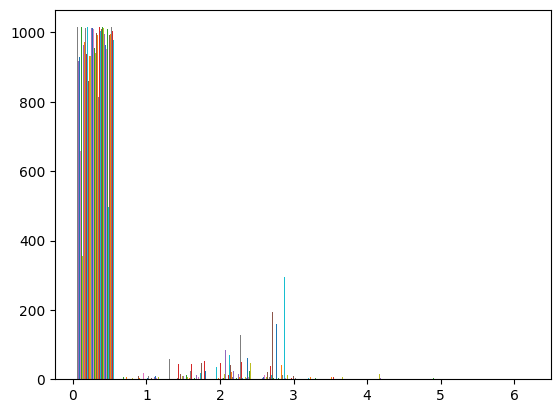

In [70]:
values = X_test.values.tolist()
values = np.asarray(values, dtype='float')
plt.hist(values)
plt.show()

In [13]:
X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train_clean, X_val_clean, X_test_clean, 'maxabs', clip=False)

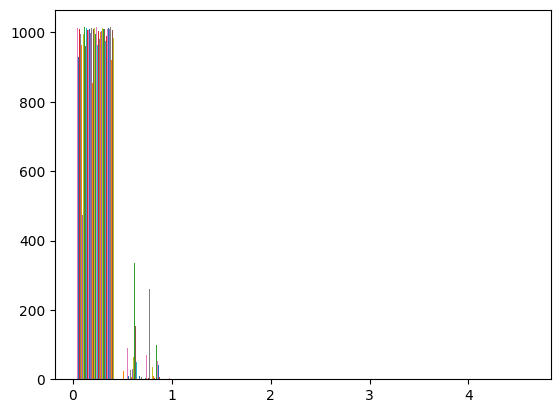

In [60]:
values = X_test_scaled.values.tolist()
values = np.asarray(values, dtype='float')
plt.hist(values)
plt.show()

In [14]:
# to_remove_filepath = calc_genes_to_remove('microglial', X_train, y_train, load = True)
to_remove_filepath = "/users/acmaytin/csci2952g/final_project/data/preprocessing_output/to_remove_microglial"
X_train_removed, X_val_removed, X_test_removed = remove_collinearity(X_train_scaled, X_val_scaled, X_test_scaled, to_remove_filepath)

Number of Features after Collinearity Removal: 15619


In [15]:
X_train_selected, X_val_selected, X_test_selected = select_features(X_train_removed, X_val_removed, X_test_removed, 'microglial')

Number of Features after LASSO feature selection: 944


In [16]:
store_selected_df('microglial', X_train_selected, X_val_selected, X_test_selected)
store_tensors('microglial', X_train_selected, X_val_selected, X_test_selected)

In [69]:
file_name = f"/users/acmaytin/csci2952g/final_project/data/preprocessing_output/tensors_microglial.pkl"

with open(file_name, "rb") as train_test_file:
    X_train_tensor = pickle.load(train_test_file)
    X_test_tensor = pickle.load(train_test_file)
    X_val_tensor = pickle.load(train_test_file)
    y_train_tensor = pickle.load(train_test_file)
    y_val_tensor = pickle.load(train_test_file)
    y_test_tensor = pickle.load(train_test_file)

# print(X_train_tensor)
# display(X_train_selected)

# print(X_val_tensor)
# display(X_val_selected)

# print(X_test_tensor)
# display(X_test_selected)

print('---------')
print(y_train_tensor.shape)
display(y_train.shape)

print('---------')
print(y_val_tensor.shape)
display(y_val.shape)

print('---------')
print(y_test_tensor.shape)
print(y_test.shape)

---------
torch.Size([3244])


(3244,)

---------
torch.Size([812])


(812,)

---------
torch.Size([1015])
(1015,)


## Astrocytes

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = clean_split_data("/users/acmaytin/csci2952g/final_project/data/cell_type_pkl_files/astrocyte.pkl")
X_train_clean, X_val_clean, X_test_clean = remove_constants(X_train, X_val, X_test)
X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train_clean, X_val_clean, X_test_clean, 'maxabs', clip=False)

Removed NaN or Constant Features: 2377
Train set has 2141 normal samples and 7260 diseased AD samples
Validation set has 535 normal samples and 1816 diseased AD samples
Test set has 669 normal samples and 2270 diseased AD samples
Removed Features Null in Training Set: 238
Number of Features: 17380


In [14]:
to_remove_filepath = calc_genes_to_remove('astrocyte', X_train, y_train, load = False)
# to_remove_filepath = "/users/acmaytin/csci2952g/final_project/data/preprocessing_output/to_remove_astrocyte"
X_train_removed, X_val_removed, X_test_removed = remove_collinearity(X_train_scaled, X_val_scaled, X_test_scaled, to_remove_filepath)

-------------------------------------------------------
Checking 107 features with correlations >= 0.8
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not a valid method
Not 

In [ ]:
X_train_selected, X_val_selected, X_test_selected = select_features(X_train_removed, X_val_removed, X_test_removed, 'astrocyte')
store_selected_df('astrocyte', X_train_selected, X_val_selected, X_test_selected)
store_tensors('astrocyte', X_train_selected, X_val_selected, X_test_selected)

## Oligodendrocyte

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = clean_split_data("/users/acmaytin/csci2952g/final_project/data/cell_type_pkl_files/oligodendrocyte.pkl")
X_train_clean, X_val_clean, X_test_clean = remove_constants(X_train, X_val, X_test)
X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train_clean, X_val_clean, X_test_clean, 'maxabs', clip=False)

In [ ]:
to_remove_filepath = calc_genes_to_remove('oligodendrocyte', X_train, y_train, load = False)
# to_remove_filepath = "/users/acmaytin/csci2952g/final_project/data/preprocessing_output/to_remove_oligodendrocyte"
X_train_removed, X_val_removed, X_test_removed = remove_collinearity(X_train_scaled, X_val_scaled, X_test_scaled, to_remove_filepath)

In [ ]:
X_train_selected, X_val_selected, X_test_selected = select_features(X_train_removed, X_val_removed, X_test_removed, 'oligodendrocyte')
store_selected_df('oligodendrocyte', X_train_selected, X_val_selected, X_test_selected)
store_tensors('oligodendrocyte', X_train_selected, X_val_selected, X_test_selected)

## GABAergic Neuron

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = clean_split_data("/users/acmaytin/csci2952g/final_project/data/cell_type_pkl_files/GABAergic.pkl", downsample=True)
X_train_clean, X_val_clean, X_test_clean = remove_constants(X_train, X_val, X_test)
X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train_clean, X_val_clean, X_test_clean, 'maxabs', clip=False)

Removed NaN or Constant Features: 1525
Train set has 9600 normal samples and 9600 diseased AD samples
Validation set has 2400 normal samples and 2400 diseased AD samples
Test set has 3000 normal samples and 3000 diseased AD samples
Removed Features Null in Training Set: 492
Number of Features: 17978


In [ ]:
to_remove_filepath = calc_genes_to_remove('GABAergic', X_train, y_train, load = False)
# to_remove_filepath = "/users/acmaytin/csci2952g/final_project/data/preprocessing_output/to_remove_GABAergic"
X_train_removed, X_val_removed, X_test_removed = remove_collinearity(X_train_scaled, X_val_scaled, X_test_scaled, to_remove_filepath)

In [ ]:
X_train_selected, X_val_selected, X_test_selected = select_features(X_train_removed, X_val_removed, X_test_removed, 'GABAergic')
store_selected_df('GABAergic', X_train_selected, X_val_selected, X_test_selected)
store_tensors('GABAergic', X_train_selected, X_val_selected, X_test_selected)

## Glutamatergic Neuron

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = clean_split_data("/users/acmaytin/csci2952g/final_project/data/cell_type_pkl_files/glutamatergic.pkl", downsample=True)
X_train_clean, X_val_clean, X_test_clean = remove_constants(X_train, X_val, X_test)
X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train_clean, X_val_clean, X_test_clean, 'maxabs', clip=False)

Removed NaN or Constant Features: 1080
Train set has 9600 normal samples and 9600 diseased AD samples
Validation set has 2400 normal samples and 2400 diseased AD samples
Test set has 3000 normal samples and 3000 diseased AD samples
Removed Features Null in Training Set: 758
Number of Features: 18157


In [14]:
to_remove_filepath = calc_genes_to_remove('glutamatergic', X_train, y_train, load = False)
# to_remove_filepath = "/users/acmaytin/csci2952g/final_project/data/preprocessing_output/to_remove_glutamatergic"
X_train_removed, X_val_removed, X_test_removed = remove_collinearity(X_train_scaled, X_val_scaled, X_test_scaled, to_remove_filepath)

In [ ]:
X_train_selected, X_val_selected, X_test_selected = select_features(X_train_removed, X_val_removed, X_test_removed, 'glutamatergic')
store_selected_df('glutamatergic', X_train_selected, X_val_selected, X_test_selected)
store_tensors('glutamatergic', X_train_selected, X_val_selected, X_test_selected)